In [1]:
import numpy as np
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from Mondrian_forest import *
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pickle

dim_in = 5
active = 2
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 2000
n_test = 1000
tries = 10


x_train, _, x_test, _, _ = pickle.load(open('axis_aligned_data.pickle', 'rb'))

x_train = x_train[:, :dim_in]
x_test = x_test[:, :dim_in]

rotation = np.identity(dim_in)
rotation[1,0] = 1
rotation[1,1] = 0
rotation[3,1] = 1.4

y_train = simulate_y(x_train, rotation)

y_test = simulate_y(x_test, rotation)

sample_range = [100, 200, 400, 800, 1600]

M = 10                      # number of Mondrian trees to use
delta = 0                   # ridge regression delta

rotation

array([[1. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. ],
       [0. , 1.4, 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 1. ]])

In [2]:
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_test, rotation)
from numpy import linalg
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n_test
norm_H = linalg.norm(true_H, ord = 2)

In [3]:
np.set_printoptions(precision=5, suppress=True)
true_H/two_one_norm(true_H)

Array([[1.30981, 1.30981, 0.     , 0.05148, 0.     ],
       [1.30981, 1.30981, 0.     , 0.05148, 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.05148, 0.05148, 0.     , 1.29181, 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     ]], dtype=float32)

In [4]:
np.linalg.matrix_rank(true_H)

2

In [5]:
def plot_trend(stats, x_axis, y_axis, title, xlabel = None, ylabel = None):
    df = pd.DataFrame(stats)

    # Prepare the data for plotting
    plot_data = [df[y_axis][i] for i in range(len(df))]

    # Create the boxplot
    plt.boxplot(plot_data, labels=[str(x[x_axis]) for x in stats])

    # Add titles and labels
    plt.title(title)
    if xlabel is None:
        xlabel = x_axis
    if ylabel is None:
        ylabel = y_axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Show the plot
    plt.show()

# Save training history

In [6]:
lifetime = 5

stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        y_hat_test, history, X_bd_all, w_trees = one_run(
            x_train[:n_sim, ], y_train[:n_sim, ], x_test, M, lifetime, delta
        )
        dist['history'].append([y_hat_test, history, X_bd_all, w_trees])
    stats.append(dist)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


# Get H estimate

In [7]:
def get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H):
    H_est = []
    for i in range(len(sample_range)):
        n_sim = sample_range[i]
        dist = {'n': n_sim, 'mse': [], 'H': []}
        for trial in tqdm(range(tries)):
            y_hat_test, history, X_bd_all, w_trees = \
                stats[i]['history'][trial]
            dist['mse'].append(mean_squared_error(y_test, y_hat_test))
            H_0 = estimate_H(x_train, y_train, X_bd_all, M, x_test, history, w_trees, y_hat_test)
            dist['H'].append(H_0)
        H_est.append(dist)
        
    return H_est

def estimate_H_finite_diff(x_train, y_train, X_bd_all, M, X_test, history, w_trees, y_hat_test):
    dim_in = X_test.shape[1]
    N_test = X_test.shape[0]
    importance = []
    for dim in range(dim_in):
        x_eval_pos = deepcopy(X_test)
        x_eval_neg = deepcopy(X_test)
        x_diff = 0.5
        x_eval_pos[:,dim] = x_eval_pos[:,dim] + x_diff/2
        x_eval_neg[:,dim] = x_eval_neg[:,dim] - x_diff/2
        
        y_eval_pos = evaluate(y_train, x_eval_pos, M, history, w_trees)
        y_eval_neg = evaluate(y_train, x_eval_neg, M, history, w_trees)
        y_diff = y_eval_pos - y_eval_neg
        importance_temp = y_diff/x_diff
        
        importance.append(importance_temp)
    importance = np.vstack(importance)

    H = np.matmul(importance, np.transpose(importance))/N_test
    return H

raw_H_estimates = get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H_finite_diff)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:27<00:00,  8.75s/it]


In [8]:
def operator_norm(H, truth):
    norm_truth = norm(truth, ord = 2)
    return norm(truth - H, ord = 2)/norm_truth

def get_eig(A):
    eigenValues, eigenVectors = linalg.eig(A)

    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenVectors

def get_angle_distance(H, truth):
    dim_proj = active
    proj = np.identity(dim_proj)
    proj = np.pad(proj, [(0, dim_in - dim_proj), (0, dim_in - dim_proj)], mode='constant')

    rank = np.linalg.matrix_rank(truth)
    
    eigenvectors = get_eig(H)
    Q_H, _ = linalg.qr(eigenvectors[:, :rank])
    
    eigenvectors = get_eig(truth)
    Q_t, _ = linalg.qr(eigenvectors[:, :rank])

    D = np.matmul(np.transpose(Q_H), Q_t)
    U, S, Vh = np.linalg.svd(D, full_matrices=True)
    S = np.minimum(S, 1)
    return np.max(np.arccos(S))

In [9]:
def plot_dist(H_estimates, title, true_H, norm_H, norm_func):
    plot_data = []
    for i in range(len(sample_range)):
        dist = H_estimates[i]
        n_sim = sample_range[i]
        alter_dist = {'n': n_sim, 'dist':[]}
        for trial in range(tries):
            H_0 = dist['H'][trial]
            alter_dist['dist'].append(norm_func(H_0, true_H))
        plot_data.append(alter_dist)
    try:
        plot_trend(plot_data, 'n', 'dist', title, ylabel='Operator distance from the True H')
    except:
        pass


def plot_H_estimates(raw_H_estimates, true_H, norm_func):

    norm_H = norm(true_H, ord = 2)
    plot_dist(raw_H_estimates, 'Unnormalised', true_H, norm_H, norm_func)

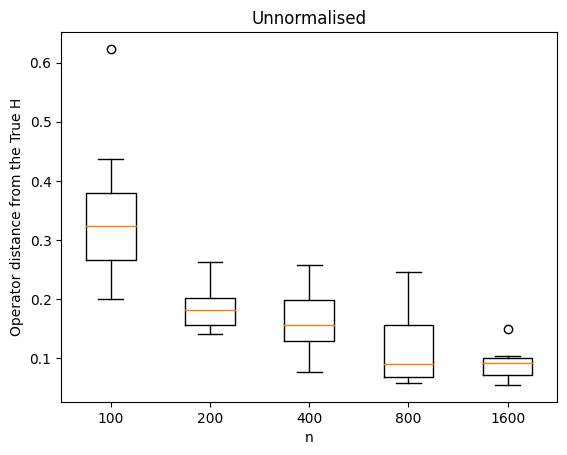

In [10]:
np.set_printoptions(precision=4)
plot_H_estimates(raw_H_estimates, true_H, get_angle_distance)

# Orginal method for estimating gradients

In [11]:
alter_H_estimates = get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H_ind)

100%|██████████| 10/10 [00:51<00:00,  5.11s/it]


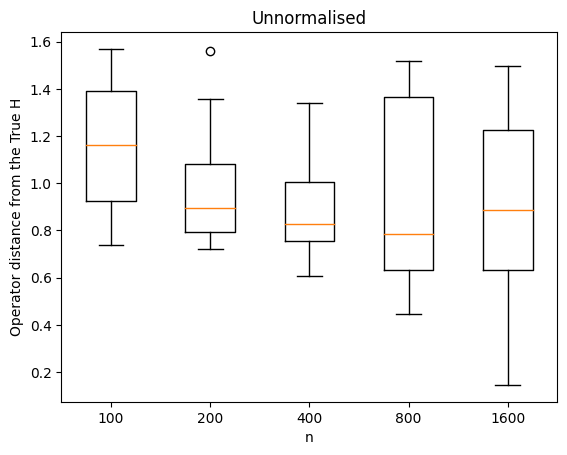

In [12]:
plot_H_estimates(alter_H_estimates, true_H, get_angle_distance)

In [13]:
lifetime_max = 5
n_sim = 1600
results = []
results.append(
    evaluate_all_lifetimes(x_train[:n_sim,], 
                           y_train[:n_sim], 
                           x_test, y_test, M, lifetime_max, delta))

In [14]:
x_train_transformed, x_test_transformed = transform_data(true_H/two_one_norm(true_H), x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

In [15]:
H_1 = raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0])

x_train_transformed, x_test_transformed = transform_data(H_1, x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

In [16]:
# subset results[0][0]['times'] whose indices mod 10 == 0

def process_times(times):
    return [times[i] for i in range(len(times)) if i % 10 == 0]

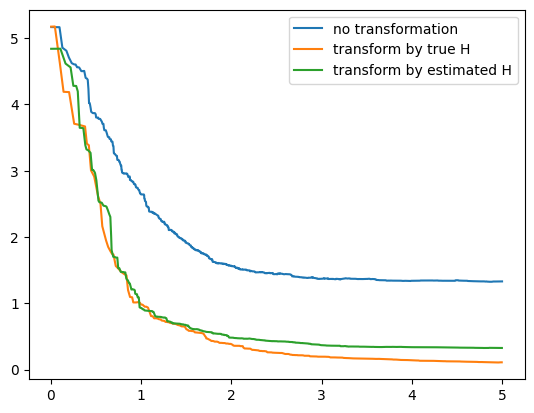

In [17]:
plt.plot(process_times(results[0][0]['times']), results[0][0]['mse'], label = 'no transformation')
plt.plot(process_times(results[1][0]['times']), results[1][0]['mse'], label = 'transform by true H')
plt.plot(process_times(results[2][0]['times']), results[2][0]['mse'], label = 'transform by estimated H')
plt.legend()

In [18]:
raw_H_estimates[4]['H'][0]

array([[ 8.6087,  6.5571,  0.0635,  0.1322, -0.1631],
       [ 6.5571,  9.2559,  0.0851,  0.1831, -0.1129],
       [ 0.0635,  0.0851,  2.076 , -0.0623, -0.1375],
       [ 0.1322,  0.1831, -0.0623,  4.802 , -0.2152],
       [-0.1631, -0.1129, -0.1375, -0.2152,  1.6043]], dtype=float32)

In [19]:
H_1

array([[ 1.402 ,  1.0678,  0.0103,  0.0215, -0.0266],
       [ 1.0678,  1.5073,  0.0139,  0.0298, -0.0184],
       [ 0.0103,  0.0139,  0.3381, -0.0101, -0.0224],
       [ 0.0215,  0.0298, -0.0101,  0.782 , -0.035 ],
       [-0.0266, -0.0184, -0.0224, -0.035 ,  0.2613]], dtype=float32)

In [20]:
true_H/two_one_norm(true_H)

Array([[1.3098, 1.3098, 0.    , 0.0515, 0.    ],
       [1.3098, 1.3098, 0.    , 0.0515, 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.0515, 0.0515, 0.    , 1.2918, 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ]], dtype=float32)

In [21]:
stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        y_hat_test, history, X_bd_all, w_trees = one_run(
            x_train_transformed[:n_sim, ], y_train[:n_sim, ], x_test_transformed, M, lifetime, delta
        )
        dist['history'].append([y_hat_test, history, X_bd_all, w_trees])
    stats.append(dist)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:06<00:00,  6.65s/it]


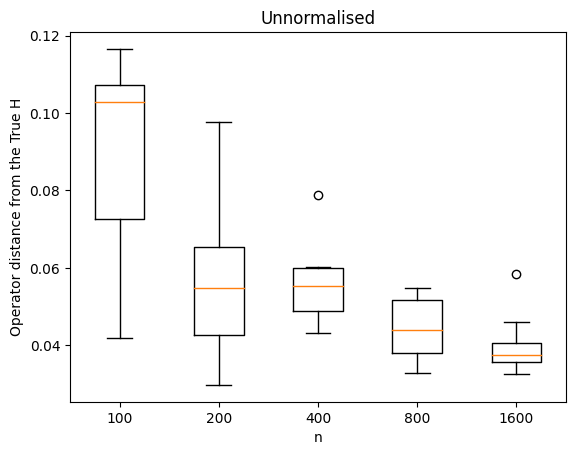

In [22]:
raw_H_estimates = get_H_estimates(stats, x_train_transformed, x_test_transformed, y_test, M, delta, estimate_H_finite_diff)

def get_angle_distance_1(H, truth):
    return get_angle_distance(np.matmul(H_1, H), truth)

plot_H_estimates(raw_H_estimates, true_H, get_angle_distance_1)

In [23]:
H_2 = raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0])

x_train_transformed, x_test_transformed = transform_data(H_2, 
                                                         x_train_transformed, x_test_transformed)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

In [24]:
H_12 = np.matmul(H_1, H_2)
H_12

array([[ 2.8727,  2.0707, -0.027 , -0.004 ,  0.0424],
       [ 2.7861,  2.1385, -0.0436, -0.0091,  0.049 ],
       [ 0.0279,  0.0069,  0.0683,  0.05  , -0.0057],
       [ 0.0578,  0.0089,  0.1555,  1.2946,  0.0324],
       [-0.0489, -0.0295, -0.0122, -0.0493,  0.0499]], dtype=float32)

In [25]:
true_H/two_one_norm(true_H)

Array([[1.3098, 1.3098, 0.    , 0.0515, 0.    ],
       [1.3098, 1.3098, 0.    , 0.0515, 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.0515, 0.0515, 0.    , 1.2918, 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ]], dtype=float32)

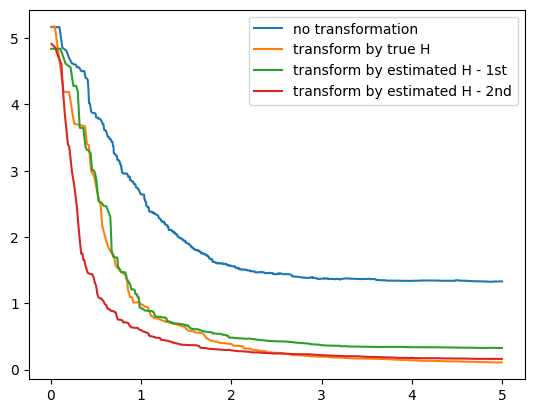

In [26]:
plt.plot(process_times(results[0][0]['times']), results[0][0]['mse'], label = 'no transformation')
plt.plot(process_times(results[1][0]['times']), results[1][0]['mse'], label = 'transform by true H')
plt.plot(process_times(results[2][0]['times']), results[2][0]['mse'], label = 'transform by estimated H - 1st')
plt.plot(process_times(results[3][0]['times']), results[3][0]['mse'], label = 'transform by estimated H - 2nd')
plt.legend()

In [27]:
stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        y_hat_test, history, X_bd_all, w_trees = one_run(
            x_train_transformed[:n_sim, ], y_train[:n_sim, ], x_test_transformed, M, lifetime, delta
        )
        dist['history'].append([y_hat_test, history, X_bd_all, w_trees])
    stats.append(dist)

100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


100%|██████████| 10/10 [00:42<00:00,  4.29s/it]


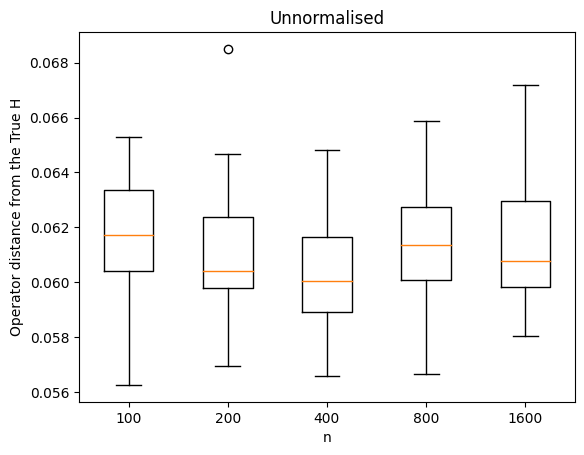

In [28]:
raw_H_estimates = get_H_estimates(stats, x_train_transformed, x_test_transformed, y_test, M, delta, estimate_H_finite_diff)

def get_angle_distance(H, truth):
    dim_proj = active
    proj = np.identity(dim_proj)
    proj = np.pad(proj, [(0, dim_in - dim_proj), (0, dim_in - dim_proj)], mode='constant')

    rank = np.linalg.matrix_rank(truth)
    
    eigenvectors = get_eig(H)
    Q_H, _ = linalg.qr(eigenvectors[:, :rank])
    
    eigenvectors = get_eig(truth)
    Q_t, _ = linalg.qr(eigenvectors[:, :rank])

    D = np.matmul(np.transpose(Q_H), Q_t)
    U, S, Vh = np.linalg.svd(D, full_matrices=True)
    S = np.minimum(S, 1)
    return np.max(np.arccos(S))

def get_angle_distance_12(H, truth):
    return get_angle_distance(np.matmul(H_12, H), truth)

plot_H_estimates(raw_H_estimates, true_H, get_angle_distance_12)

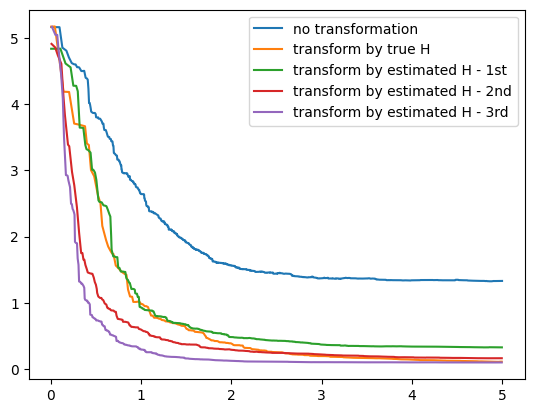

In [29]:
H_3 = raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0])
x_train_transformed, x_test_transformed = transform_data(H_3, 
                                                         x_train_transformed, x_test_transformed)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

plt.plot(process_times(results[0][0]['times']), results[0][0]['mse'], label = 'no transformation')
plt.plot(process_times(results[1][0]['times']), results[1][0]['mse'], label = 'transform by true H')
plt.plot(process_times(results[2][0]['times']), results[2][0]['mse'], label = 'transform by estimated H - 1st')
plt.plot(process_times(results[3][0]['times']), results[3][0]['mse'], label = 'transform by estimated H - 2nd')
plt.plot(process_times(results[4][0]['times']), results[4][0]['mse'], label = 'transform by estimated H - 3rd')
plt.legend()

In [39]:
H_12/two_one_norm(H_12)

array([[ 1.6815,  1.2121, -0.0158, -0.0024,  0.0248],
       [ 1.6308,  1.2517, -0.0255, -0.0053,  0.0287],
       [ 0.0163,  0.0041,  0.04  ,  0.0293, -0.0034],
       [ 0.0338,  0.0052,  0.091 ,  0.7578,  0.019 ],
       [-0.0286, -0.0173, -0.0071, -0.0288,  0.0292]], dtype=float32)

In [37]:
H_123 = np.matmul(H_12, H_3)
H_123/two_one_norm(H_123)

array([[ 1.0783,  1.1489, -0.2506,  0.0242,  0.1401],
       [ 1.0717,  1.1529, -0.2537,  0.0162,  0.1393],
       [ 0.0051,  0.0034,  0.0181,  0.0575,  0.0067],
       [ 0.0211,  0.0077,  0.3005,  1.1467,  0.1284],
       [-0.0158, -0.0157, -0.0075, -0.0406, -0.0051]], dtype=float32)

In [36]:
true_H/two_one_norm(true_H)

Array([[1.3098, 1.3098, 0.    , 0.0515, 0.    ],
       [1.3098, 1.3098, 0.    , 0.0515, 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.0515, 0.0515, 0.    , 1.2918, 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ]], dtype=float32)